# IBM AI Enterprise Workflow Capstone

## Part 1: Data Investigation

## Table of Contents
* [Introduction](#first-bullet)
* [Data Ingestion](#second-bullet)
* [Data Visualization](#third-bullet)

## Introduction <a class="anchor" id="first-bullet"></a>

AAVAIL is a video streaming company whose customer feedback has prompted consideration for an adjustment to their current subscription-based business model. The business objective is as follows:
- Build a tool that, at any point in time, can project revenue for the following month for a specific country.

The data includes transaction-level purchases for 38 countries over a couple years and a few thousand users. A revenue projection tool would save time for managers and provide more accurate predictions, leading to stabilized staffing and budget projections. For ease of use, an API is requested to automate the entire process, including the data ingestion and model deployment. 

Testable Hypotheses:
1. An automated prediction tool will be ore accurate than the current method implemented by the managers.
2. The data provided from past years is correlated with future data.

Ideal Data:
- Our goal is to have revenue broken down by country and month. Other features (e.g. country, price, product, etc.) will be needed in order to accurately create our prediction model.

## Data Ingestion <a class="anchor" id="second-bullet"></a>

Convert the provided data into a workable format that is ideal for the business opportunity and the end product. 
- The initial JSON files are loaded and concatenated into a dataframe. Variables are reformatted into the proper data types and column names are adjusted to reduce redundancy. 
- The dataframe is converted to time series data by aggegrating over each day. 
- Load the time series dataframe. Top ten countries based on revenue are identified and saved into individual CSV files.

In [1]:
%%writefile data_ingestion.py

import os
import sys
import re
import time
import shutil
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd


def fetch_data(data_dir):

    '''
    load json files into dataframe
    '''

    if not os.path.isdir(data_dir):
        raise Exception('data directory does not exist')
    if not len(os.listdir(data_dir)) > 0:
        raise Exception('data directory contains zero files')

    file_list = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if re.search('\.json', f)]
    correct_columns = ['country', 'customer_id', 'day', 'invoice', 'month',
                       'price', 'stream_id', 'times_viewed', 'year']

    all_months = {}
    for file_name in file_list:
        df = pd.read_json(file_name)
        all_months[os.path.split(file_name)[-1]] = df

    for f,vdf in all_months.items():
        cols = set(df.columns.tolist())
        if 'StreamID' in cols:
             df.rename(columns = {'StreamID':'stream_id'}, inplace = True)
        if 'TimesViewed' in cols:
            df.rename(columns = {'TimesViewed':'times_viewed'}, inplace = True)
        if 'total_price' in cols:
            df.rename(columns = {'total_price':'price'}, inplace = True)

        cols = df.columns.tolist()
        if sorted(cols) != correct_columns:
            raise Exception('columns name could not be matched to correct columns')

    df = pd.concat(list(all_months.values()), ignore_index = True)
    
    years, months, days = df['year'].values, df['month'].values, df['day'].values 
    dates = ['{}-{}-{}'.format(years[i], str(months[i]).zfill(2), str(days[i]).zfill(2)) for i in range(df.shape[0])]
    
    df['invoice_date'] = np.array(dates, dtype = 'datetime64[D]')
    df['invoice'] = [re.sub('\D+','',i) for i in df['invoice'].values]
    
    df.sort_values(by = 'invoice_date', inplace = True)
    
    df.reset_index(drop = True, inplace = True)
    
    return(df)


def convert_to_ts(df_orig, country = None):

    '''
    take in dataframe and return a time series dataframe by aggregating over each day
    '''

    if country:
        if country not in np.unique(df_orig['country'].values):
            raise Excpetion('country not found')
    
        mask = df_orig['country'] == country
        df = df_orig[mask]
    else:
        df = df_orig
        
    invoice_dates = df['invoice_date'].values
    
    start_month = '{}-{}'.format(df['year'].values[0], str(df['month'].values[0]).zfill(2))
    stop_month = '{}-{}'.format(df['year'].values[-1], str(df['month'].values[-1]).zfill(2))
    
    df_dates = df['invoice_date'].values.astype('datetime64[D]')
    
    days = np.arange(start_month, stop_month, dtype = 'datetime64[D]')
    purchases = np.array([np.where(df_dates == day)[0].size for day in days])
    invoices = [np.unique(df[df_dates == day]['invoice'].values).size for day in days]
    streams = [np.unique(df[df_dates == day]['stream_id'].values).size for day in days]
    views =  [df[df_dates == day]['times_viewed'].values.sum() for day in days]
    revenue = [df[df_dates == day]['price'].values.sum() for day in days]
    year_month = ['-'.join(re.split('-', str(day))[:2]) for day in days]

    df_time = pd.DataFrame({'date':days,
                            'purchases':purchases,
                            'unique_invoices':invoices,
                            'unique_streams':streams,
                            'total_views':views,
                            'year_month':year_month,
                            'revenue':revenue})
    return(df_time)


def fetch_ts(data_dir, clean = False):

    '''
    load time series dataframe
    '''

    ts_data_dir = os.path.join(data_dir, 'train-ts')
    
    if clean:
        shutil.rmtree(ts_data_dir)
    if not os.path.exists(ts_data_dir):
        os.mkdir(ts_data_dir)
     
    if len(os.listdir(ts_data_dir)) > 0:
        return({re.sub('\.csv', '', cf)[3:]:pd.read_csv(os.path.join(ts_data_dir, cf)) for cf in os.listdir(ts_data_dir)})

    df = fetch_data(data_dir)

    table = pd.pivot_table(df, index = 'country', values = "price", aggfunc = 'sum')
    
    table.columns = ['total_revenue']
    
    table.sort_values(by = 'total_revenue', inplace = True, ascending = False)
    
    top_ten_countries =  np.array(list(table.index))[:10]

    file_list = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if re.search('\.json', f)]
    countries = [os.path.join(data_dir, 'ts-' + re.sub('\s+', '_', c.lower()) + '.csv') for c in top_ten_countries]

    dfs = {}
    
    dfs['all'] = convert_to_ts(df)
    
    for country in top_ten_countries:
        country_id = re.sub('\s+', '_', country.lower())
        file_name = os.path.join(data_dir, 'ts-' + country_id + '.csv')
        dfs[country_id] = convert_to_ts(df, country = country)
  
    for key, item in dfs.items():
        item.to_csv(os.path.join(ts_data_dir, 'ts-' + key + '.csv'), index = False)
        
    return(dfs)


if __name__ == '__main__':

    run_start = time.time()
    
    data_dir = os.path.join('.', 'data', 'cs-train')

    ts_all = fetch_ts(data_dir, clean = False)

    m, s = divmod(time.time() - run_start, 60)
    h, m = divmod(m, 60)
    
    print('run time:', '%d:%02d:%02d'%(h, m, s))

    print('Data Loaded:')
    
    for key, item in ts_all.items():
        print(key, item.shape)

Overwriting data_ingestion.py


In [2]:
%run data_ingestion.py

run time: 0:00:00
Data Loaded:
portugal (607, 7)
belgium (607, 7)
united_kingdom (607, 7)
hong_kong (426, 7)
eire (607, 7)
france (607, 7)
singapore (456, 7)
all (607, 7)
norway (577, 7)
germany (607, 7)
netherlands (607, 7)


## Data Visualization <a class="anchor" id="third-bullet"></a>

Create visualizations to gain further insight into the data and investigate its relationship to the business metric. 
- Total monthly revenue for all markets plotted over time. 
- Breakdown of revenue by each market.
- Correlation between revenue and the remaining provided variables. 

In [136]:
%%writefile data_visualization.py

import re
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data_ingestion import fetch_ts


def create_plots(df):
    
    '''
    plot visualizations from dataframe
    '''
    
    plt.style.use('ggplot')
    
    # total monthly revenue 
    df['all'].groupby(['year_month']).sum()['revenue'].plot()
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    plt.title('Monthly Revenue for All Markets')
    plt.show()
    
    # revenue breakdown by country
    x = list(df.keys())
    x.remove('all')
    x_pos = [i for i, _ in enumerate(x)]
    
    rev_vals = []
    for country in x:
        rev_vals.append(df[country]['revenue'].sum())

    plt.bar(x_pos, rev_vals, color = 'lightblue')
    plt.xlabel('Country')
    plt.ylabel('Revenue')
    plt.yscale('log')
    plt.title('Revenue Breakdown by Country')
    plt.xticks(x_pos, x, rotation = 70)
    plt.show()
    
    # heatmap
    corr = (df['all']).corr()
    
    sns.heatmap(corr, annot = True, cmap = 'Blues')
    plt.show()

    
if __name__ == '__main__':
    
    run_start = time.time()
    
    data_dir = os.path.join('.', 'data', 'cs-train')
    df = fetch_ts(data_dir)
    
    create_plots(df)
    
    m, s = divmod(time.time() - run_start, 60)
    h, m = divmod(m, 60)
    
    print('run time:', '%d:%02d:%02d'%(h, m, s))
    print('data visualization complete')

Overwriting data_visualization.py


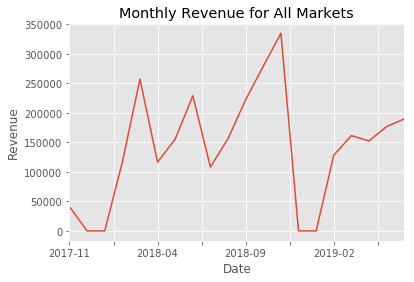

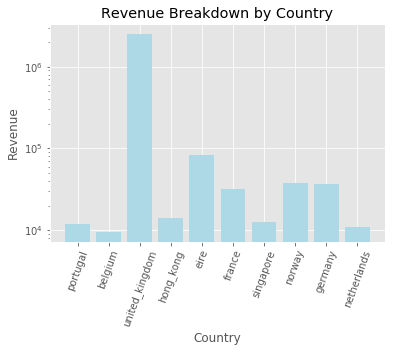

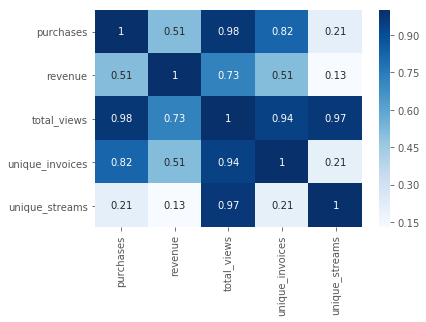

run time: 0:00:01
data visualization complete


In [137]:
%run data_visualization.py